# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 11**

<img src="var_11.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


In [517]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from matplotlib.colors import ListedColormap
from time import perf_counter
from tqdm import trange

In [504]:
class HeatProbe:
    """
    Point inside the model which can save its temperature
    """
    def __init__(self, x: int, y: int):
        """
        Keyword arguments:
        x: int - position along x axis
        y: int - position along y axis
        """
        self.x = x
        self.y = y
        self.temperature_history = []
    def write_temperature(self, M: np.ndarray) -> None:
        """
        Saves current temperature
        Keyword arguments:
        M: np.ndarray - matrix of temperatures
        """
        self.temperature_history.append(M[self.y, self.x])

In [505]:
class HeatSource:
    """
    Rectangle inside the model which produces heat 
    """
    def __init__(self, x:int, y:int, width:int, height: int, p:float, theta:float):
        """
        Keyword arguments:
        x: int - position along x axis
        y: int - position along y axis
        width: int - length along x axis
        height: int - length along y axis
        p: float - amplitude of power fluctation
        theta: float - period of power fluctaion
        """
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.p = p
        self.theta = theta
    def get_power(self, t:float) -> float:
        """
        Calculates power of the source at moment t
        Keyword arguments:
        t: float - point in time
        Returns:
        float - power of the source
        """
        return self.p * (np.sin(2 * np.pi * t / self.theta) + 1)
    def add_heat(self, M: np.ndarray, t: float, dt: float) -> None:
        """
        Adds heat to model
        Keyword arguments:
        M: np.ndarray - matrix of temperatures
        t: float - point in time
        dt: float - time interval
        """
        power = self.get_power(t)
        M[(self.y-self.height):self.y, self.x:(self.x + self.width)] += dt * power      

In [520]:
class HeatTransferModel:
    """
    Class that simulates heat transfer in 2D space
    """
    def __init__(self,
                 N: int,
                 L: int,
                 dt:float,
                 D0: float,
                 D1:float,
        ):
        """
        Keyword argumsents:
        N: int - number of points along both axis
        L: int - distance along both axis
        dt: float - size of time interval
        D0: float - diffusion coefficient of main material
        D1: float - diffusion coefficient of included material
        """
        self.N = N
        self.L = L
        self.dx = L/N
        self.dt = dt
        self.D0 = D0
        self.D1 = D1
        self.D = np.full((N,N), D0, dtype=float)
        self.current_state = np.zeros((N,N), dtype=float)
        self.next_state = np.zeros((N,N), dtype=float)
        self.heat_sources = []
        self.heat_probes = []

    def add_heat_source(self, x:int, y:int, width:int, height:int, p:float, theta:float) -> None:
        """
        Adds heat source to model
        Keyword arguments:
        x: int - position of the source along x axis
        y: int - position of the source along y axis
        width: int - length of the source along x axis
        height: int - length of the source along y axis
        p: float - amplitude of power fluctation
        theta: float - period of power fluctaion
        """
        self.heat_sources.append(HeatSource(x, y, width, height, p, theta))

    def add_heat_probe(self, x: int, y:int) -> None:
        """
        Adds heat probe to model
        Keyword arguments:
        x: int - position of the probe along x axis
        y: int - position of the probe along y axis
        """
        self.heat_probes.append((HeatProbe(x, y)))
    
    def add_inclusion_rect(self, x:int, y:int, width:int, height:int) -> None:
        """
        Adds rectangle made of included material to model
        Keyword arguments:
        x: int - position of the inclusion along x axis
        y: int - position of the inclusion along y axis
        width: int - length of the inclusion along x axis
        height: int - length of the inclusion along y axis
        """
        self.D[y - height: y, x: x + width] = self.D1
    
    def set_permanent_temperature(self, Tx: float, Ty:float):
        """
        sets permanent temperature for x = 0 and y = 0
        Tx: float - temperature along x = 0
        Ty: float - temperature along y = 0
        """
        self.current_state[0, :] = Ty
        self.current_state[:, 0] = Tx
    
    def apply_boundary_conditions(self):
        """
        makes x = N - 1 and y = N - 1 thermal isolated
        """
        self.next_state[:, -1] = self.next_state[:, -2]
        self.next_state[-1, :] = self.next_state[-2, :]
    
    def add_heat_from_sources(self, t):
        """
        Adds heat to the model from all sources
        t: float - point in time
        """
        for source in self.heat_sources:
            source.add_heat(self.current_state, t, self.dt)
    
    def write_probes_tempreature(self):
        """
        Writes temperature of all probes
        """
        for probe in self.heat_probes:
            probe.write_temperature(self.next_state)
     
    @staticmethod
    @njit(parallel=True)
    def heat_diffusion(N: int, dt: float, dx:float, D:np.ndarray, current_state:np.ndarray, next_state:np.ndarray):
        """
        Calculetes heat diffusion via finite-difference method applied to heat differential equation
        N: int - number of points along both axis
        dt: float - time interval
        dx: float - distance between points in array with neighboring indexes
        D: np.ndarray - array of floats with size (N,N) with corresponding diffusion coefficeints
        current_state: np.ndarray - array of floats with size (N,N) with corresponding heat before diffusion
        next_state: np.ndarray - array of floats with size (N,N) with corresponding heat after diffusion
        """
        for row in prange(1, N-1):
            for column in range(1, N-1):
                g = dt * D[row, column] / dx ** 2
                next_state[row, column] = current_state[row, column] + g * (
                    current_state[row - 1, column] +
                    current_state[row, column - 1] +
                    current_state[row + 1, column] +
                    current_state[row, column + 1] -
                    4 * current_state[row, column]
                )
    def forward(self, iteration: int) -> np.ndarray: 
        """
        Calculates next step of heat transfer model
        """
        t = iteration * self.dt
        self.add_heat_from_sources(t)
        HeatTransferModel.heat_diffusion(
            self.N,
            self.dt,
            self.dx,
            self.D,
            self.current_state,
            self.next_state
        )
        self.apply_boundary_conditions()
        self.write_probes_temperature()
        self.next_state, self.current_state = self.current_state, self.next_state
        return self.current_state
    
    def show_diffusion_matrix(self):
        """
        Displays diffusion matrix
        """
        plt.figure(figsize=(10,10))
        ticks = np.arange(0, self.N + 1, self.N//12)
        tick_labels = np.arange(0, self.L + 1, self.L//12)
        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)
        cmap = ListedColormap(["white", "blue"])
        plt.pcolormesh(model.D, cmap = cmap)
        plt.grid(linestyle = '--', linewidth = 1)
        plt.axis('square')
        plt.title("Diffusion matrix")
        colorbar = plt.colorbar()
        colorbar.set_ticks(ticks=[self.D1, self.D0],labels=["included_material", "main_material"])
        plt.show()
    
    def show_model_scheme(self):
        """
        Displays model scheme
        """
        plt.figure(figsize=(10,10))
        ticks = np.arange(0, self.N + 1, self.N//12)
        tick_labels = np.arange(0, self.L + 1, self.L//12)
        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)
        image = np.copy(model.D)
        for source in self.heat_sources:
            image[source.y - source.height: source.y, source.x: source.x + source.width] = 3*self.D0
        cmap = ListedColormap(["white", "blue", "black", "orange"])
        plt.pcolormesh(image, cmap = cmap,zorder=1)
        plt.grid(linestyle = '--', linewidth = 1,zorder=2)
        plt.axis('square')
        plt.title("Heat transfer model scheme")
        colorbar = plt.colorbar()
        colorbar.set_ticks(
            ticks=[self.D1, self.D0, 2*self.D0, 3 * self.D0],
            labels=["included_material", "main_material", "heat_probe", "heat_source"]
        )
        for ind, probe in enumerate(self.heat_probes):
            plt.scatter(probe.y, probe.x, c="black", s= 24,zorder=3)
            plt.annotate(ind, (probe.y, probe.x), (probe.y + N//L,probe.x + N//L), c="black", fontsize=16)
        plt.show()
    
    def show_model_temperature(self):
        """
        Displays current temperature matrix
        """
        plt.figure(figsize=(10,10))
        ticks = np.arange(0, self.N + 1, self.N//12)
        tick_labels = np.arange(0, self.L + 1, self.L//12)
        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)
        plt.pcolormesh(self.current_state, cmap = "inferno")
        plt.title("Heat map")
        plt.colorbar()
        plt.axis('square')
        plt.show()

In [507]:
L = 60
t = 600
D0 = 1.0
D1 = 0.01
p0 = 100
theta0 = 43
p1 = 100
theta1 = 77

In [521]:
def create_heat_transfer_model(
    N: int,
    L: int,
    dt: float,
    D0: int,
    D1: int,
    p0: float,
    theta0:float,
    p1:float,
    theta1:float,
    Tx:float,
    Ty:float,
):
    """
    Creates heat transfer model according to task scheme
    """
    model = HeatTransferModel(N, L, dt, D0, D1)
    model.add_heat_source(N // 12, 2 * N // 3, N // 12, N // 3, p0, theta0)
    model.add_heat_source(N // 3, N // 6, N // 3, N // 12, p1, theta1)
    model.add_heat_probe(N // 3, N // 3)
    model.add_heat_probe(2 * N // 3, N // 3)
    model.add_heat_probe(2 * N // 3, 2 * N // 3)
    model.add_heat_probe(N // 3, 2 * N // 3)
    model.add_inclusion_rect(N // 6, N // 2, N // 12, N // 3)
    model.add_inclusion_rect(N // 4, N // 2, N // 4, N // 12)
    model.add_inclusion_rect(5 * N // 12, 5 * N // 12, N // 12, N // 4)
    model.add_inclusion_rect(N // 3, N // 4, N // 12, N // 12)
    model.add_permanent_temperature(Tx, Ty)
    return model

In [509]:
dt = 1.0
N = 60
model = create_heat_transfer_model(N, L, t, dt, D0, D1, p0, theta0, p1, theta1)

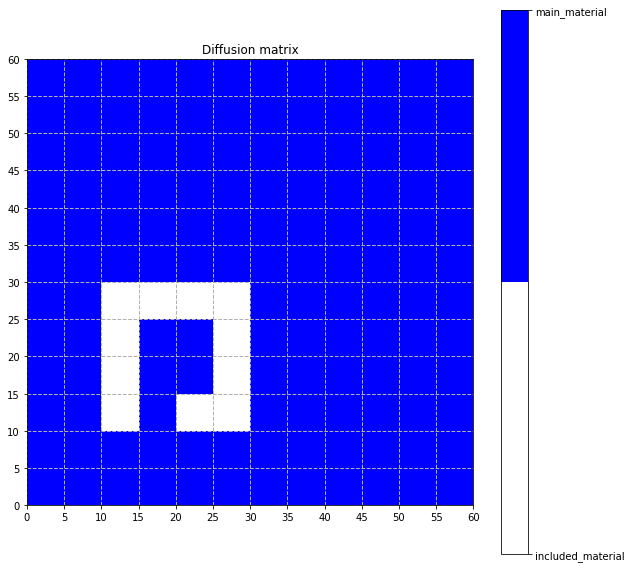

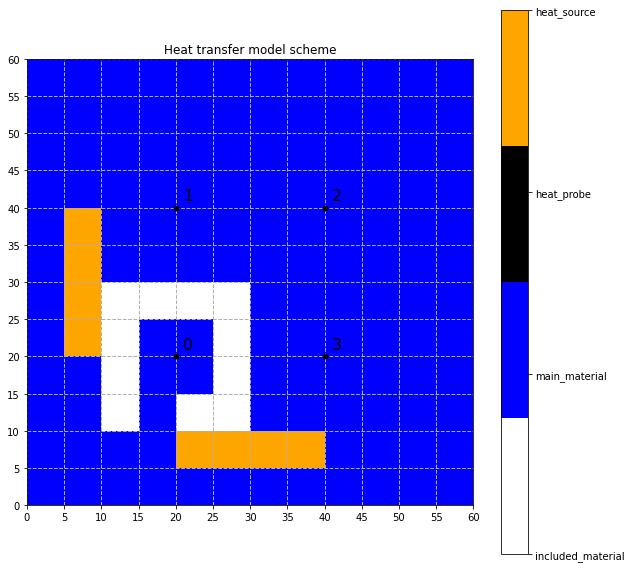

In [510]:
model.show_diffusion_matrix()
model.show_model_scheme()

In [511]:
dt = 0.01
N = 60
model = create_heat_transfer_model(N, L, t, dt, D0, D1, p0, theta0, p1, theta1)

100%|████████████████████████████████| 300001/300001 [00:28<00:00, 10694.73it/s]


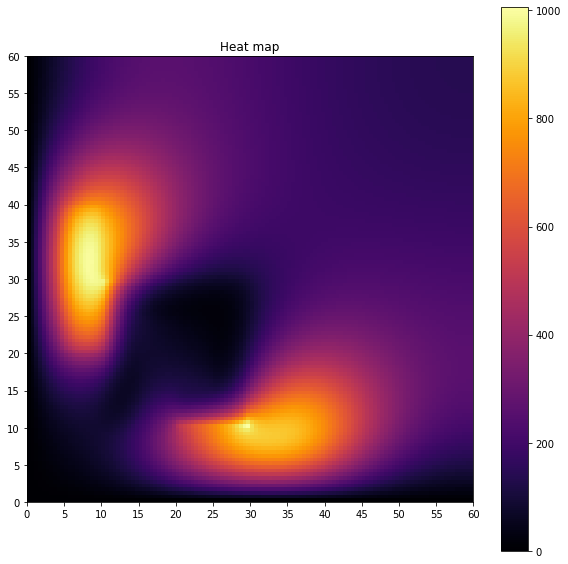

In [522]:
dt = 0.002
N = 120
model = create_heat_transfer_model(N, L, t, dt, D0, D1, p0, theta0, p1, theta1)
n_iter = int(t/dt) + 1
for i in trange(n_iter):
    model.forward(i)
model.show_model_temperature()